# 11. 메타 학습
## 11.3 MAML - 분류 문제

In [1]:
import torch
from torch import nn, optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as tr
from torch.utils.data import DataLoader, Dataset
from matplotlib import pyplot as plt
import numpy as np
import copy

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
cd/content/gdrive/My Drive/pytorch_dlbro

/content/gdrive/My Drive/pytorch_dlbro


In [4]:
# GPU vs CPU
# 현재 가능한 장치를 확인한다.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [5]:
class MyTransform:
    
    def __call__(self, sample, mode):
        inputs1, inputs2, labels = sample
        if mode == "train":
            transf = tr.RandomHorizontalFlip()
            output1 = transf(inputs1) 
        else:
            output1 = inputs1
                  
        return output1, inputs2, labels 

In [6]:
class TensorData(Dataset):

    def __init__(self, support_set, query_set, labels, mode="train"):
        self.support_set = torch.FloatTensor(support_set).permute(0,3,1,2)
        self.query_set = torch.FloatTensor(query_set).permute(0,3,1,2)
        self.labels = torch.LongTensor(labels)
        self.len = self.labels.shape[0]
        self.transform = MyTransform()
        self.mode = mode

    def __getitem__(self, index):

        sample = self.support_set[index], self.query_set[index], self.labels[index]
        sample = self.transform(sample, self.mode) 
        return sample

    def __len__(self):
        return self.len

class CIFAR100DataSet:
    def __init__(self, Nway=5, fewshot=5):
        self.cifar = torchvision.datasets.CIFAR100(root='./data', train=True, download=True)
        self.Nway = Nway
        self.fewshot = fewshot

    def task_generator(self, cls, mode="train"):
        
        labels = np.array(self.cifar.targets)
        data = self.cifar.data / 255
        
        support_set = []
        query_set = []
        targets = []
        for i, c in enumerate(cls):
            
            idx = np.where(labels == c)[0]
            rand = np.random.choice(len(idx), 2*self.fewshot, replace=False)
            for shot in range(2*self.fewshot):
                img = data[idx[rand[shot]]]

                if shot < self.fewshot:
                    support_set.append(img)
                    targets.append(i)
                else:
                    query_set.append(img)  

        support_set = np.stack(support_set)
        query_set = np.stack(query_set)
        targets = np.array(targets)
        taskset = TensorData(support_set, query_set, targets, mode=mode)
        dataloader = torch.utils.data.DataLoader(taskset, batch_size=self.Nway*self.fewshot, shuffle=False)
        return dataloader

    def task_set(self, num_tasks, cls, mode="train"):
        task_collection = []
        for i in range(num_tasks):
            task_collection.append(self.task_generator(cls, mode=mode))
        return task_collection   


In [7]:
Nway = 5
fewshot = 5

In [8]:
cifar100 = CIFAR100DataSet(Nway=Nway, fewshot=fewshot)

Files already downloaded and verified


torch.Size([25, 3, 32, 32]) torch.Size([25, 3, 32, 32]) torch.Size([25])


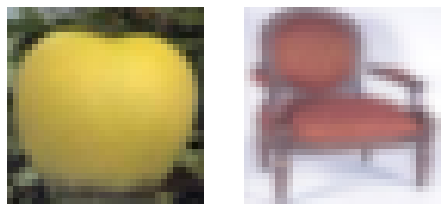

In [9]:
trainloader = cifar100.task_generator(cls=[0,10,20,50,70])
data1, data2, label = iter(trainloader).next()
print(data1.size(), data2.size(), label.size())
oneshot1 = data1[0].permute(1,2,0).numpy()
oneshot2 = data2[10].permute(1,2,0).numpy()
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.imshow(oneshot1)
plt.axis("off")
plt.subplot(132)
plt.imshow(oneshot2)
plt.axis("off")
plt.show()

In [10]:
class CNN(nn.Module):
    def __init__(self, Nway):
        super(CNN, self).__init__()
        self.features = nn.Sequential(
                        nn.Conv2d(3, 64, 3), nn.ReLU(),
                        nn.MaxPool2d(2, 2),
                        nn.Conv2d(64, 128, 3, stride=1, padding=1), nn.ReLU(),
                        nn.MaxPool2d(2, 2),
                        nn.Conv2d(128, 256, 3, stride=1, padding=1), nn.ReLU(),
                        nn.Conv2d(256, 256, 3, stride=1), nn.ReLU(),
                        nn.Conv2d(256, 256, 3, stride=1), nn.ReLU())
 
        self.classifier = nn.Sequential(nn.Linear(256, 128) , nn.ReLU(), nn.Linear(128, Nway)) 
        
    def forward(self, x): # 모델 연산의 순서를 정의
        x = self.features(x)
        x = torch.mean(x, [2,3])
        x = self.classifier(x)
        return x

    def parameterised(self, x, weights):
        x = F.relu(F.conv2d(x, weight=weights[0], bias=weights[1], stride=1))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = F.relu(F.conv2d(x, weight=weights[2], bias=weights[3], stride=1, padding=1))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = F.relu(F.conv2d(x, weight=weights[4], bias=weights[5], stride=1, padding=1))
        x = F.relu(F.conv2d(x, weight=weights[6], bias=weights[7], stride=1))
        x = F.relu(F.conv2d(x, weight=weights[8], bias=weights[9], stride=1))
        x = torch.mean(x, [2,3])
        x = F.relu(F.linear(x, weights[10], weights[11]))
        x = F.linear(x, weights[12], weights[13])
        return x    

In [11]:
class MAML:
    def __init__(self, num_tasks=300, Nway=5, alpha = 1e-3, beta = 1e-3, inner_steps=1, cls=None):
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")    
        self.num_tasks = num_tasks
        self.model = CNN(Nway).to(device)
        self.weights = list(self.model.parameters())
        self.beta = beta
        self.cifar100 = CIFAR100DataSet()
        self.task_collection = self.cifar100.task_set(num_tasks=self.num_tasks, cls=cls[:60], mode="train")
        self.meta_val_set = self.cifar100.task_set(num_tasks=30, cls=cls[60:], mode="val")
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=alpha, weight_decay=1e-4)
        self.inner_steps = inner_steps

    def inner_loop(self, dataloader):
       
        temp_weights = [w.clone() for w in self.weights]
        data = iter(dataloader).next()
        support, query, label = data[0].to(device), data[1].to(device), data[2].to(device)
        for i in range(self.inner_steps):
            outputs = self.model.parameterised(support, temp_weights)
            loss = self.criterion(outputs, label)
            grad = torch.autograd.grad(loss, temp_weights)
            temp_weights = [w - self.beta * g for w, g in zip(temp_weights, grad)]
                  
        outputs = self.model.parameterised(query, temp_weights)    
        inner_loss = self.criterion(outputs, label)

        return inner_loss

    def meta_train(self, num_epochs):      
        loss_list = []
        acc = 0
        for epoch in range(num_epochs):
            torch.cuda.empty_cache()
            self.optimizer.zero_grad()
            outer_loss = 0
            #self.weights = list(self.model.parameters())
           
            for i in range(self.num_tasks):
                outer_loss += self.inner_loop(self.task_collection[i])
                
            avg_loss = outer_loss/self.num_tasks
            avg_loss.backward()
            self.optimizer.step()
            ll = avg_loss.item()
            loss_list.append(ll)
            
            val_acc = self.meta_val()
            if epoch % 10 == 0:
                print('[%d] Train loss: %.3f, Validation accuracy: %.2f %%' %(epoch, ll, val_acc))
             
            if val_acc >= acc:
                acc = val_acc
                print('Saved the model - Validation accuracy: %.2f %%' % (val_acc))   
                torch.save(self.model.state_dict(), './models/cifar_maml.pth') 
          
        return loss_list

    def meta_val(self):

        acc_list = []
        for i in range(len(self.meta_val_set)):
            cnn = copy.deepcopy(self.model)
            criterion = nn.CrossEntropyLoss()
            opt = optim.Adam(cnn.parameters(), lr=1e-2)
            num_epochs = 101
            testloader = self.meta_val_set[i]
            data1, data2, label = iter(testloader).next()
            cnn.train() 
            for j in range(num_epochs):
                opt.zero_grad()
                outputs = cnn(data1.to(device))
                loss = criterion(outputs, label.to(device))
                loss.backward()
                opt.step()
                
            correct = 0
            total = 0
            with torch.no_grad():
                cnn.eval()  
                outputs = cnn(data2.to(device))
                _, predicted = torch.max(outputs.data, 1)
                total += label.size(0)
                correct += (predicted == label.to(device)).sum().item()
            
            acc_list.append(100 * correct / total)
            
        acc_info = np.array(acc_list)
        avg_acc = np.mean(acc_info)
        return avg_acc

In [12]:
cls = np.random.choice(range(0, 100), 100, replace=False)

In [ ]:
maml = MAML(num_tasks=300, Nway=Nway, cls=cls[:80])
loss = maml.meta_train(501)

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(loss)
plt.show()

In [13]:
def meta_test(task_collection, pretrained=None):

    acc_list = []
    for i in range(len(task_collection)):
        cnn = CNN(Nway).to(device)
        if pretrained == 'meta':
            cnn.load_state_dict(torch.load('./models/cifar_maml.pth'))
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(cnn.parameters(), lr=1e-2)
        num_epochs = 101
        testloader = task_collection[i]
        data1, data2, label = iter(testloader).next()
        cnn.train() 
        for j in range(num_epochs):
            optimizer.zero_grad()
            outputs = cnn(data1.to(device))
            loss = criterion(outputs, label.to(device))
            loss.backward()
            optimizer.step()
            
        correct = 0
        total = 0
        with torch.no_grad():
            cnn.eval()  
            outputs = cnn(data2.to(device))
            _, predicted = torch.max(outputs.data, 1)
            total += label.size(0)
            correct += (predicted == label.to(device)).sum().item()
        
        acc_list.append(100 * correct / total)
        
    acc_info = np.array(acc_list)
    print('Avg. Test accuracy: %.2f %% ± %.2f' % (np.mean(acc_info), 1.96*np.std(acc_info)/np.sqrt(len(acc_info))))   

In [14]:
meta_test_set = cifar100.task_set(num_tasks=100, cls=cls[80:])

In [15]:
meta_test(meta_test_set, 'meta')

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Avg. Test accuracy: 39.76 % ± 2.21


In [16]:
meta_test(meta_test_set)

Avg. Test accuracy: 33.56 % ± 2.21
